In [209]:
from helperFunctions import *
from constants import *
import pyeeg


In [210]:
# Load XDF File

"""
Files that work
part_P001_block_S001.xdf # This does not have the cross hair
part_P002_block_S001.xdf # These have cross hairs
part_P003_block_S001.xdf 

These experiments consist of the user looking at faces vs landscape as labeled by the Markers. 
In the more recent experiments, there are also cross hairs for the subject to fixate on before 
each new image is shown. 
"""
filename = "part_P002_block_S001"

XDF_Path = "./data/"+filename+".xdf"
XDF_Data = loadxdf(XDF_Path)

# Print the sampling frequency if found
if StreamType.EEG.value in XDF_Data : 
    eeg_fs = getEEGfs(XDF_Data) # int(XDF_Data[StreamType.EEG.value][StreamType.FS.value])
    print("eeg_fs = ", eeg_fs)
    
# Cut the data to drop anything before the psychopy stimuli presentation
XDF_Data = epochByMarkIndex(0, -1, XDF_Data)

eeg_fs =  128


In [211]:
# Measures from NeuroSky [Raw EEG, Attention, Meditation, Blinks]
print(sum(XDF_Data[StreamType.EEG.value][StreamType.DATA.value][:,3]), "blinks detected")

0.0 blinks detected


In [212]:
def convertRawToMicroVolts(raw_values):
    # http://support.neurosky.com/kb/science/how-to-convert-raw-values-to-voltage 
    # Converts an array of NeuroSky raw values into an array of millivolts 
    return (np.array(np.array(raw_values) * (1.8/4096)) / 2) * 1000

In [213]:
def getEEGDataInMilliVolts(original_data):
    eeg_data = original_data[StreamType.EEG.value][StreamType.DATA.value][:,0]
    eeg_data_in_volts = convertRawToMicroVolts(eeg_data)
    return eeg_data_in_volts

In [214]:
def zeroTime(raw_timepoints):
    # Takes an array of timepoints and returns the zeroed version (where the )
    return np.array(np.array(raw_timepoints) - raw_timepoints[0])

In [215]:
def plotEEG(original_data):
    eeg_data_in_volts = getEEGDataInMilliVolts(original_data)
    timepoints = original_data[StreamType.EEG.value][StreamType.TIME.value]
    
    plt.plot(timepoints, eeg_data_in_volts)

In [216]:
def plotAttention(original_data):
    data = original_data[StreamType.EEG.value][StreamType.DATA.value][:,1]
    timepoints = original_data[StreamType.EEG.value][StreamType.TIME.value]
    
    plt.plot(timepoints, data)
    

In [217]:
def plotMeditation(original_data):
    data = original_data[StreamType.EEG.value][StreamType.DATA.value][:,2]
    timepoints = original_data[StreamType.EEG.value][StreamType.TIME.value]
    
    plt.plot(timepoints, data)

In [219]:
def plotPSD(original_data, f_range=(0.5, 50), cut_off=-1):
    eeg_data_in_volts = getEEGDataInMilliVolts(original_data)
    
    sig_filt = filt.filter_signal(eeg_data_in_volts, eeg_fs, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
    freq, psd = signal.periodogram(sig_filt, fs=int(eeg_fs), scaling='spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.title('Raw PSD for one electrode')
    plt.plot(freq[:cut_off], psd[:cut_off])


In [242]:
def tidyNumList(lists, verbose=False):
    minimum_length = min(map(len, lists))
    cleaned_list = lists.copy()
    if minimum_length < 2: 
        toRemove = [i for i in range(len(lists)) if len(lists[i]) < 1]
        for i in toRemove:
            cleaned_list.pop(i)
        if verbose: 
            print("removed from lists:", [i for i in range(len(lists)) if len(lists[i]) < 1])
    minimum_length = min(map(len, cleaned_list))
    if verbose: 
        print("min length:", minimum_length)
    new_list = [cleaned_list[i][:minimum_length] for i in range(len(cleaned_list))]
    return new_list

In [244]:
## Getting bins for pyeeg.bin_power ## 
def getIntervals(binning): 
    intervals = list()
    for i, val in enumerate(binning[:-1]): 
        intervals.append((val, binning[i+1]))
    return intervals

In [246]:
def getPowerRatio(eeg_data, binning, eeg_fs=250):
    power, power_ratio = pyeeg.bin_power(eeg_data, binning, eeg_fs)
    return np.array(power_ratio)

In [247]:
def getSEM(numbers) :
    return (np.std(numbers, axis=0) * 2) / np.sqrt(len(numbers))


In [248]:
def getPowerRatioAvgSEM(eeg_list, num_eeg_timepoints=499, binning=full_binning): 
    power_ratio = [getPowerRatio(data[:num_eeg_timepoints], binning) for data in eeg_list]
    return np.mean(power_ratio, axis=0), getSEM(power_ratio)

In [249]:
def plotMultipleBarGraphs(bars, bar_width, bar_names, group_names, error_values=None, title=None, xlabel=None, ylabel=None): 
    if len(bar_names) != len(bars):
        print("group names must be same length as bars")
        return 
    # Set position of bar on X axis
    positions = list()
    positions.append(np.arange(len(bars[0])))
    for i, bar in enumerate(bars): 
        if i>0: 
            positions.append([x + bar_width for x in positions[i-1]])

    # Make the plot
    for i, pos in enumerate(positions):
        plt.bar(pos, bars[i], width=bar_width, label=bar_names[i])
    
    if error_values: 
        for i, pos in enumerate(positions):
            plt.errorbar(pos, bars[i], yerr=error_values[i], fmt='.k')
    
    # Add xticks on the middle of the group bars
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)
    if title: 
        plt.title(title)
    plt.xticks([r + bar_width for r in range(len(bars[0]))], group_names)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

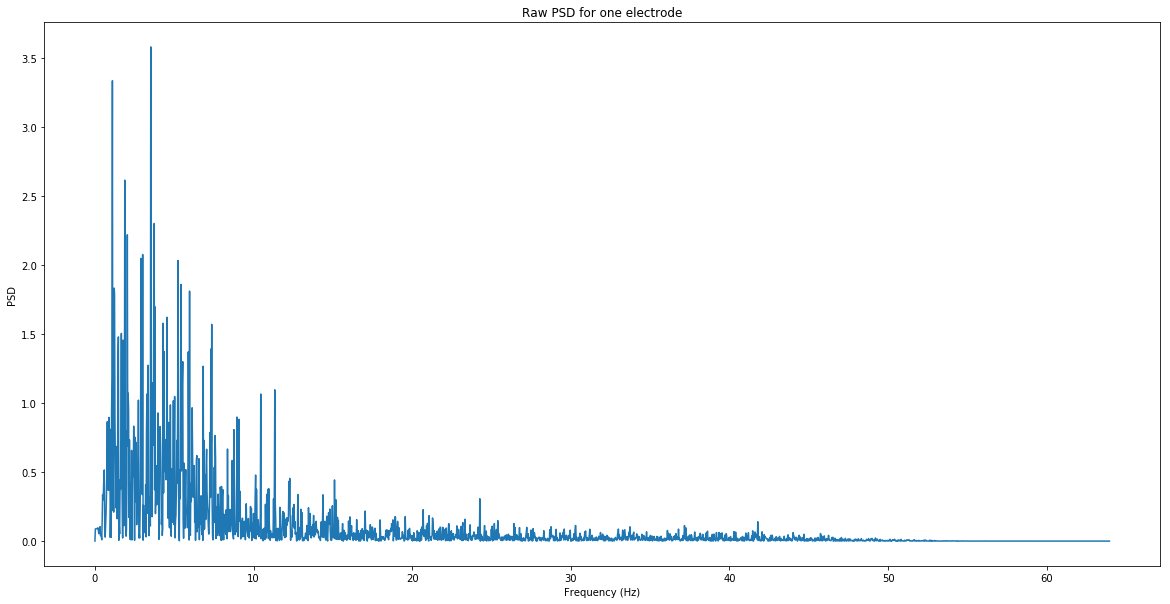

In [206]:
plt.figure(figsize=(20,10))

plotPSD(XDF_Data)

plt.show()

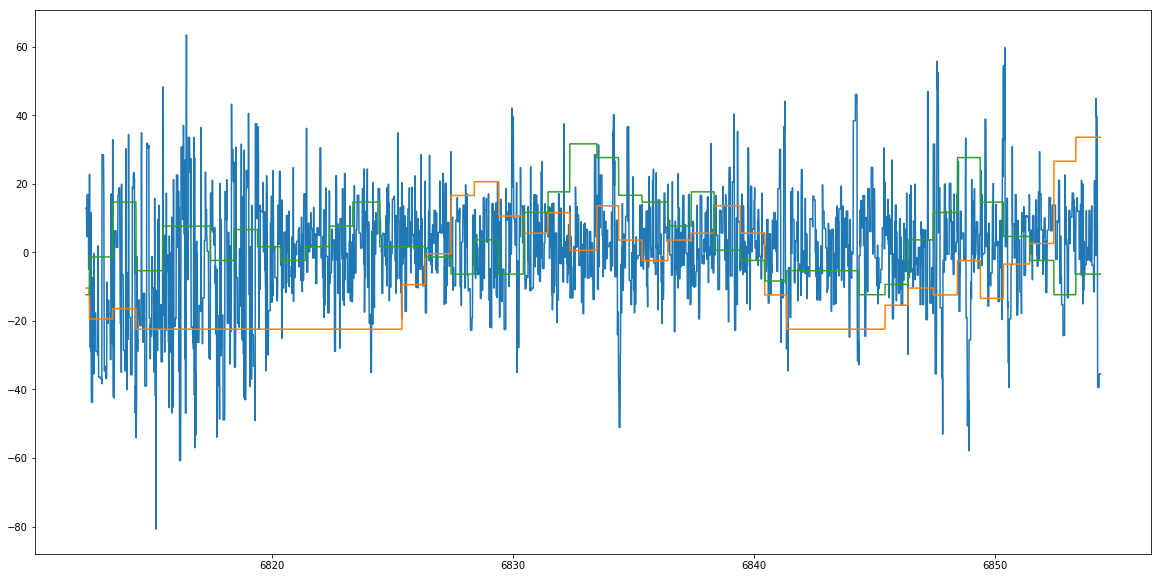

In [262]:
plt.figure(figsize=(20,10))

plotEEG(XDF_Data)
plotAttention(XDF_Data)
plotMeditation(XDF_Data)

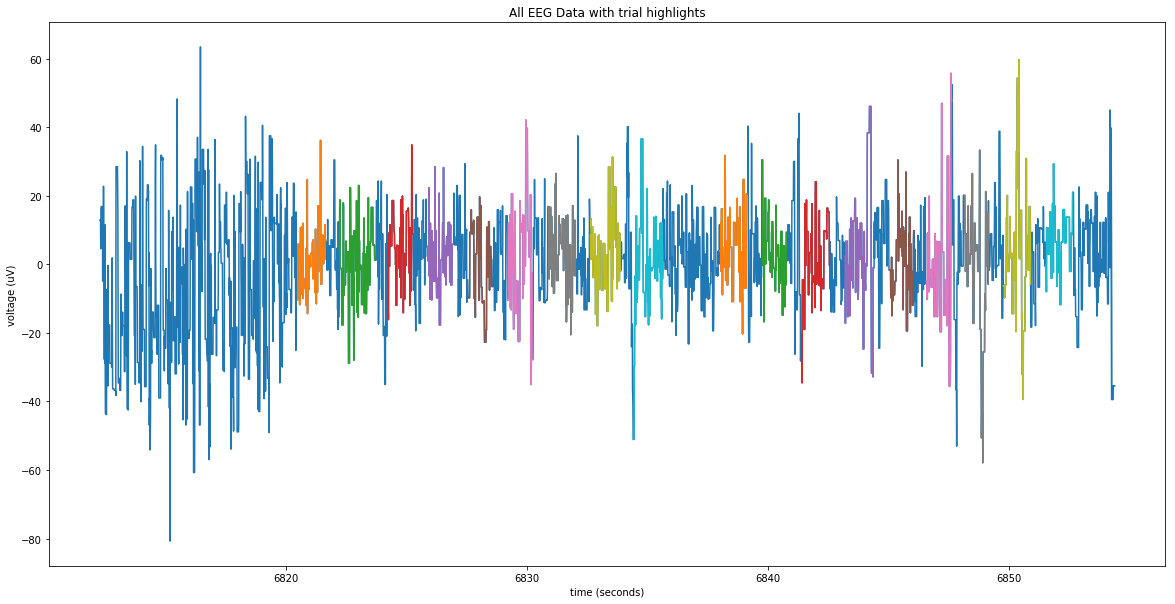

In [264]:
plt.figure(figsize=(20,10))

plotEEG(XDF_Data)

trials, _, _ = getMarkerBoundSingleMarkerData('NewImageStart', 'NewImageEnd', XDF_Data, go_backward=False)
for i, trial in enumerate(trials):
    plotEEG(trial)

plt.xlabel("time (seconds)")
plt.ylabel("voltage (uV)")
plt.title("All EEG Data with trial highlights")
plt.show()


In [251]:
# Find min length of eeg
min_len = None
for trial in trials: 
    eeg_data_in_volts = getEEGDataInMilliVolts(trial)
    if not min_len or len(eeg_data_in_volts) < min_len:
        min_len = len(eeg_data_in_volts)

# Find psd and freqs
psds=[]
freqs=[]
face_eeg = []
landscape_eeg = []
for trial in trials: 
    eeg_data_in_volts = getEEGDataInMilliVolts(trial)
    
    sig_filt = filt.filter_signal(eeg_data_in_volts[:min_len], eeg_fs, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
    freq, psd = signal.periodogram(sig_filt, fs=int(eeg_fs), scaling='spectrum')
    psds.append(psd)
    freqs.append(freq)
    if 'Face' in trial[StreamType.MARKER.value][StreamType.DATA.value]: 
        face_eeg.append(eeg_data_in_volts)
    else :
        landscape_eeg.append(eeg_data_in_volts)
    
    
    

In [245]:
# Create a binning interval
full_binning=list(np.arange(.5, 30, 2))
full_intervals = getIntervals(full_binning)

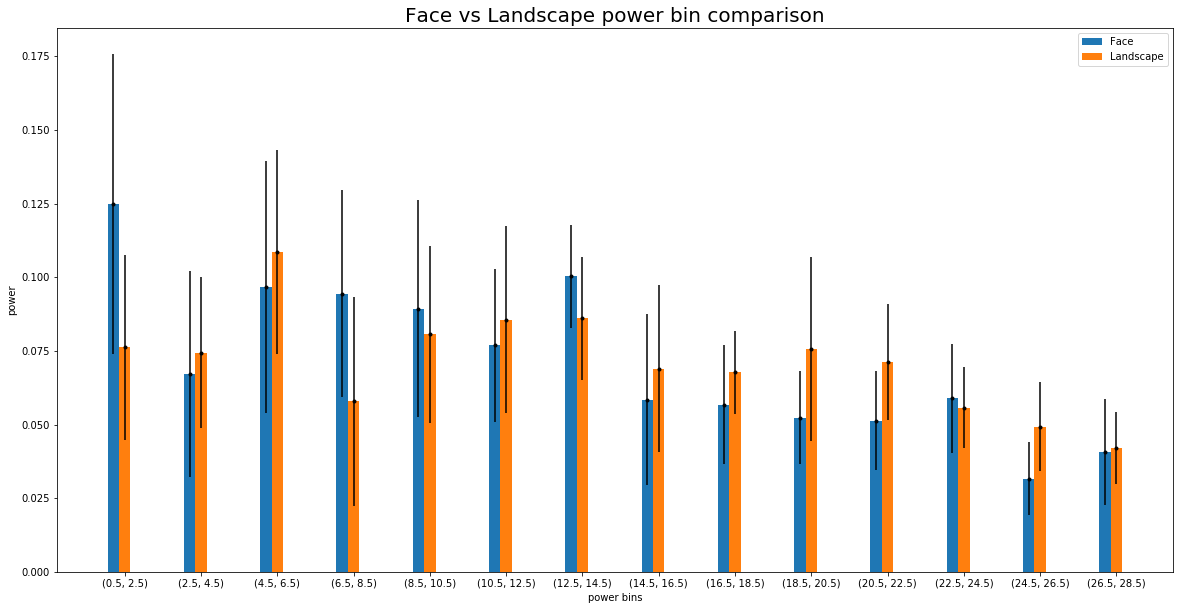

In [259]:
face_ratio_avg, face_sem = getPowerRatioAvgSEM(face_eeg, num_eeg_timepoints=-1, binning=full_binning) 
landscape_ratio_avg, landscape_sem = getPowerRatioAvgSEM(landscape_eeg, num_eeg_timepoints=-1, binning=full_binning) 

plt.figure(figsize=(20,10))
plt.title("Face vs Landscape power bin comparison", size=20)
plt.xlabel("power bins")
plt.ylabel("power")
plotMultipleBarGraphs([face_ratio_avg, landscape_ratio_avg], 0.15, ["Face", "Landscape"], full_intervals, error_values=[face_sem, landscape_sem])


In [260]:
# Create a binning interval
sub_binning=[4, 7, 12, 30]
sub_intervals = getIntervals(sub_binning)

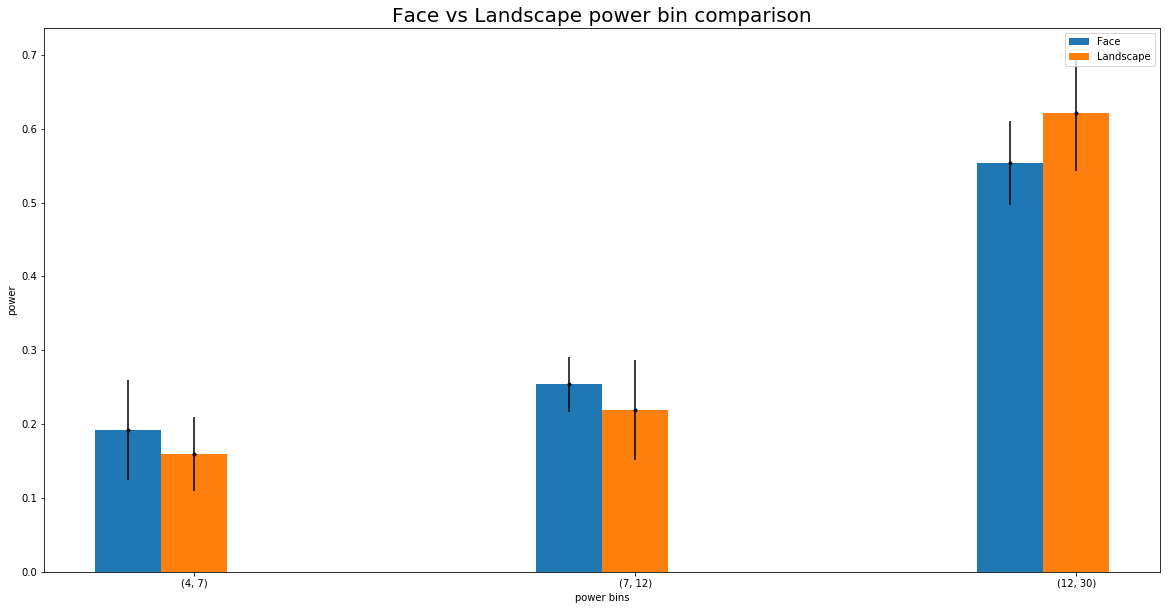

In [261]:
face_ratio_avg, face_sem = getPowerRatioAvgSEM(face_eeg, num_eeg_timepoints=-1, binning=sub_binning) 
landscape_ratio_avg, landscape_sem = getPowerRatioAvgSEM(landscape_eeg, num_eeg_timepoints=-1, binning=sub_binning) 

plt.figure(figsize=(20,10))
plt.title("Face vs Landscape power bin comparison", size=20)
plt.xlabel("power bins")
plt.ylabel("power")
plotMultipleBarGraphs([face_ratio_avg, landscape_ratio_avg], 0.15, ["Face", "Landscape"], sub_intervals, error_values=[face_sem, landscape_sem])
